Importo librerie e monto il drive:

In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
import tarfile
from shutil import copyfile

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carico i file:

In [3]:
copyfile("/content/drive/MyDrive/digital signal/consegna_assignments/Copia di recordings.tar", "recordings.tar")
tar=tarfile.open("recordings.tar")
tar.extractall()
tar.close()

In [4]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            #signal scorre gli sound_data dei vari recordings, feature extractor
            #lo sostituirò con un'effettiva estrazione di feature (e non l'identità)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.1, random_state = 1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]
        #normalizzo anche il test set ma con VAR e E del train (abbiamo visto
        #in FDL che normalizzare propriamente il train è teoricamente sbagliato)

    return X_train, X_test, y_train, y_test

Traino, ottimizzo e valuto le performance usando ogni volta una diversa **feature** tra quelle richieste:

**1)feats_spectorgram**:

In [5]:
def feats_spectrogram(input, rate = 8000, tsize = 10):
  [spec_freqs, spec_times, spec] = spectrogram(input, fs = rate)
  out_spec = spec[:,0:min(spec.shape[1],tsize)]
  out_spec = np.concatenate((out_spec, np.zeros((out_spec.shape[0],tsize-out_spec.shape[1]))), axis = 1)
  out_spec = out_spec.flatten()
  return out_spec

In [8]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_spectrogram, normalize=True)

In [9]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 29.921s


In [10]:
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.005


In [11]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.58      0.70      0.64        10
           2       0.77      0.67      0.71        15
           3       0.65      0.58      0.61        19
           4       0.30      0.27      0.29        11
           5       0.75      0.64      0.69        14
           6       0.18      0.64      0.28        14
           7       0.67      0.32      0.43        19
           8       0.80      0.24      0.36        17
           9       0.67      0.43      0.52        14

    accuracy                           0.50       150
   macro avg       0.62      0.51      0.52       150
weighted avg       0.64      0.50      0.53       150



Confusion matrix:


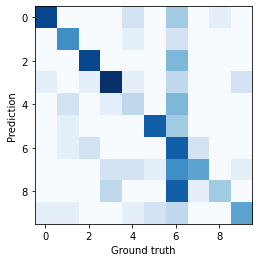

In [12]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.ylabel('Ground truth');
plt.xlabel('Prediction');

**2)feats_melspec**:

In [6]:
def feats_melspec(input, rate = 8000, tsize = 10):
  input = melspectrogram(y = input*1.0, sr = rate)
  output = input[:,0:min(input.shape[1],tsize)]
  output = np.concatenate((output, np.zeros((output.shape[0],tsize-output.shape[1]))), axis = 1)
  output = output.flatten()
  return output

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_melspec, normalize=True)

In [14]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 21.756s


In [15]:
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.005


In [16]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.94      0.44        17
           1       0.67      0.60      0.63        10
           2       0.64      0.60      0.62        15
           3       0.80      0.63      0.71        19
           4       0.44      0.36      0.40        11
           5       0.71      0.71      0.71        14
           6       0.62      0.36      0.45        14
           7       0.83      0.53      0.65        19
           8       0.78      0.41      0.54        17
           9       0.80      0.29      0.42        14

    accuracy                           0.55       150
   macro avg       0.66      0.54      0.56       150
weighted avg       0.67      0.55      0.56       150



Confusion matrix:


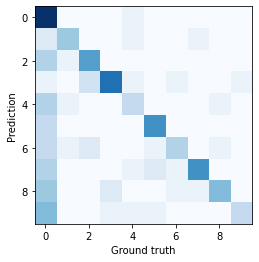

In [17]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.ylabel('Ground truth');
plt.xlabel('Prediction');

**3)feats_mfcc**:

In [7]:
def feats_mfcc(input, rate = 8000, tsize = 10):
  input = mfcc(y = input*1.0, sr = rate)
  output = input[:,0:min(input.shape[1],tsize)]
  output = np.concatenate((output, np.zeros((output.shape[0],tsize-output.shape[1]))), axis = 1)
  output = output.flatten()
  return output

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True)

In [20]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 5.577s


In [21]:
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.005


In [22]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Confusion matrix:


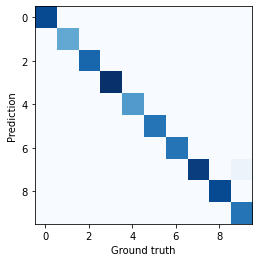

In [23]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.ylabel('Ground truth');
plt.xlabel('Prediction');